In [1]:
from scipy.integrate import odeint
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt, cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import numpy as np


In [34]:
#set up grid
nx,ny = 100,100
x = np.linspace(0, nx, nx + 1)
y = np.linspace(0, ny, ny + 1)
X, Y = np.meshgrid(x, y)
L = 1
delta = L/nx


#charge density
rho = np.zeros([nx+1,ny+1],float)
rho[40:60,:] = 1e12* (1.6e-19) #C/m^2
rho[40,:] = 1e12* (1.6e-19) + 1e-7 *np.sin(1*x)
epsilon = 8.85e-12 #F/m

#time steps
steps = 10
dt = 1e-8

#magnetic field
B = 0.1 #Tesla

In [27]:
print (X.shape)

(101, 101)


In [3]:
# trial 1: not including periodic side boundary 
#create the A matrix
def create_A(nx,ny):
    A = np.zeros(((nx-1)*(ny-1),(nx-1)*(ny-1)),float)
    np.fill_diagonal(A,-4)
    np.fill_diagonal(A[:-1,1:],1)
    np.fill_diagonal(A[1:,:-1],1)

    # fill the identity matrix after first 100 rows
    # fill the identity matrix after first 100 columns
    np.fill_diagonal(A[nx-1:,:-(nx-1)],1)
    np.fill_diagonal(A[:-(nx-1),nx-1:],1)

    # fill 0s for the corners of T
    for i in range (1,(nx-1)*(nx-1)):
        for j in range (1,(ny-1)*(ny-1)):
            if (i)%(nx-1) == 0 and (j+1)%(ny-1) == 0:
                A[i,j] = 0
            if (i+1)%(nx-1) == 0 and (j)%(ny-1) == 0:
                A[i,j] = 0

    return A

def create_sparse_tridiagonal(nx, ny):
    num_diag = (nx-1)*(nx-1)
    diag = np.full(num_diag, -4)
    lower = np.full((num_diag-1),1)
    upper = np.full((num_diag-1),1)
    identity = np.full(num_diag-(nx-1),1)

    lower[nx-2::nx-1] = 0
    upper[nx-2::nx-1] = 0


    diagonal = [diag,lower,upper,identity,identity]
    offsets = [0,-1,1,-(nx-1),(nx-1)]

    return diags(diagonal, offsets, shape =(num_diag, num_diag), format= 'csr')
  #  return diags(diagonal, offsets, shape =(num_diag, num_diag)).toarray()

 #construct boundary vector B
def create_B():
    lil_B1 = np.zeros(((nx-1)*(ny-1),1),float)
    lil_B2 = np.zeros(((nx-1)*(ny-1),1),float)
    f = rho[1:nx,1:ny].reshape((nx-1)*(ny-1),1)*delta**2/epsilon

    lil_B1[0:nx-1] = -rho[1:ny,0].reshape(nx-1,1)
    lil_B1[(nx-1)*(ny-1)-(nx-1):(nx-1)*(ny-1)] = -rho[1:ny,ny].reshape(nx-1,1)

    lil_B2[0:(nx-1)*(ny-1):(ny-1)] = -rho[1:nx,0].reshape(nx-1,1)
    lil_B2[ny-2:(nx-1)*(ny-1):(ny-1)] = -rho[1:nx,ny].reshape(nx-1,1)

    return lil_B1+lil_B2+f

#hmm if its wrapped around, then left side = right side
#so we only need to solve one side and copy the values to the other side


def solve_poisson(rho):
    A = create_sparse_tridiagonal(nx,ny)
    B = create_B()
    rho_interior = rho[1:nx,1:ny].reshape((nx-1)*(ny-1),1)
    rho_interior = spsolve(A,B)
    rho[1:nx,1:ny] = rho_interior.reshape(nx-1,ny-1)
    #rho = side_rho_1(rho)
    return rho



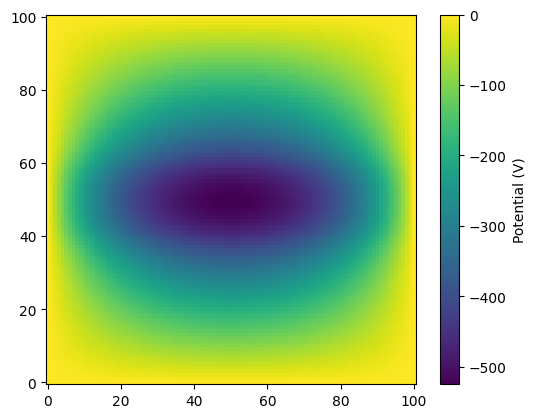

In [4]:
rho = np.zeros([nx+1,ny+1],float)
rho[40:60,:] = 1e12* (1.6e-19) #C/m^2
rho_interior = solve_poisson(rho)
plt.imshow(rho_interior, origin = 'lower')
plt.colorbar(label="Potential (V)",shrink=1)


In [5]:
# trial 2: including periodic side boundary
def create_sparse_tridiagonal_1(nx, ny):
    num_diag = (nx+1)*(ny-1)
    diag = np.full(num_diag, -4)
    lower = np.full((num_diag-1),1)
    upper = np.full((num_diag-1),1)
    identity = np.full(num_diag-(nx-1),1)
    side = np.full(ny-1,1)

    lower[nx-2::nx-1] = 0
    upper[nx-2::nx-1] = 0


    diagonal = [diag,lower,upper,identity,identity,side,side]
    offsets = [0,-1,1,-(nx-1),(nx-1),-nx*(ny-1),nx*(ny-1)]

    return diags(diagonal, offsets, shape =(num_diag, num_diag), format= 'csr')

#construct boundary vector B
def create_B_1(rho):
    lil_B2 = np.zeros(((nx+1)*(ny-1),1),float)
    f = rho[1:nx,0:ny+1].reshape((nx+1)*(ny-1),1,order = 'F')*delta**2/epsilon

    lil_B2[0:(nx+1)*(ny-1):(ny-1)] = -rho[0,0:nx+1].reshape((ny+1),1)
    lil_B2[ny-2:(nx+1)*(ny-1):(ny-1)] = -rho[ny,0:nx+1].reshape(ny+1,1)

    return lil_B2+f

def solve_poisson_1(rho):
    phi = np.zeros([nx+1,ny+1],float)
    A = create_sparse_tridiagonal_1(nx,ny)
    B = create_B_1(rho)
    phi_flat = phi.flatten(order= 'F') 
    phi_flat= spsolve(A,B)
    phi[1:nx,0:ny+1] = phi_flat.reshape(nx-1,ny+1,order = 'F')
    return phi

In [45]:
def electric_field(phi):
    Ex = np.zeros([nx+1, ny+1], float)
    Ey = np.zeros([nx+1, ny+1], float)

    for i in range(1, nx):
        for j in range(1, ny):
            #row of an array is 'i' (y-direction)
            #column of an array is 'j' (x-direction)
            Ex[i, j] = -(phi[i, j + 1] - phi[i, j - 1]) / (2*delta)
            Ey[i, j] = -(phi[i + 1, j] - phi[i - 1, j]) / (2*delta)


    plt.show()
    return Ex, Ey

def velocity(Ex, Ey, B):
    vx = np.zeros([nx+1, ny+1], float)
    vy = np.zeros([nx+1, ny+1], float)

    for i in range(1, nx):
        for j in range(1, ny):
            vx[i, j] = Ey[i, j] / B
            vy[i, j] = -Ex[i, j] / B

    return vx, vy

#forward Euler method
def forward_euler_charge_density(rho, vx, vy, dt):
    rho_new_time = rho.copy()
    for n in range(1):
        for i in range(1, nx):
            for j in range(1, ny):
                # not sure vx and vy should be at i,j or i+1,j or i-1,j
                #rho_new_time[i, j] = rho[i, j] - dt *( (rho[i +1, j]  - rho[i - 1, j] )* vx[i, j] /  (2*delta) +
                #                                    (rho[i, j+1]  - rho[i, j - 1] ) * vy[i, j]/ (2*delta)  )
                rho_new_time[i, j] = rho[i, j] - dt *( (rho[i, j]  - rho[i - 1, j] )* vx[i, j] /  (1*delta) +
                                                   (rho[i, j]  - rho[i, j - 1] ) * vy[i, j]/ (1*delta)  )
                #rho_new_time[i, j] = rho[i, j] - dt * ( (rho[i , j] * vx[i, j] - rho[i - 1, j] * vx[i - 1, j]) /  delta +
                #                                    (rho[i, j] * vy[i, j] - rho[i, j - 1] * vy[i, j - 1]) / delta )
        rho = rho_new_time.copy()
    return rho_new_time


"\n# not sure if this is correct: using ODE solver to solve charge density\ndef charge_density_ode(time_span, rho, vx, vy):\n    rho= rho.reshape((nx+1, ny+1))\n    dndt = np.zeros_like(rho)\n    #dndt[0, :] = 0\n    #dndt[nx, :] = 0\n       \n    for i in range(1, nx):\n        for j in range(1, ny):\n            dndt[i, j] = - ( (rho[i + 1, j] * vx[i + 1, j] - rho[i - 1, j] * vx[i - 1, j]) / (2 * delta) +\n                             (rho[i, j + 1] * vy[i, j + 1] - rho[i, j - 1] * vy[i, j - 1]) / (2 * delta) )\n    return dndt.flatten()\n\ndef solve_rho_ode(vx,vy,rho):\n    #vx, vy = velocity(Ex, Ey, B)\n    time_span = (0.0, 0.01)\n    time_intervals = np.linspace(0.0, 0.01,20)\n    rho_0 = rho.flatten()\n    sol = solve_ivp(charge_density_ode, time_span, rho_0, method='BDF', t_eval=time_intervals, args=(vx, vy))\n    rho_new = sol.y[:,0]\n    return rho_new.reshape(nx+1, ny+1)\n\nEx, Ey = electric_field(phi)\nvx, vy = velocity(Ex, Ey, B)\nplt.imshow(solve_rho_ode(vx,vy,rho), origi

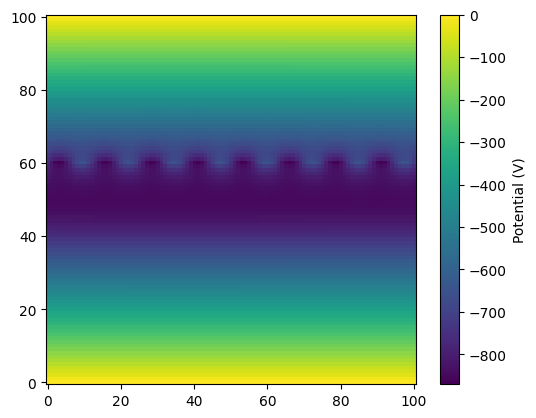

In [56]:
# solve Poisson equation with Matrix Inversion
rho = np.zeros([nx+1,ny+1],float)
rho[40:60,:] = 1e12* (1.6e-19) #C/m^2
X_exp, Y_exp= X[:,:],Y[:,:] 
rho[60,:] = 1e12* (1.6e-19) + 1e-5 *np.sin(0.5*x)
plt.imshow(rho, origin = 'lower')

phi = solve_poisson_1(rho)
plt.imshow(phi, origin = 'lower')
plt.colorbar(label="Potential (V)",shrink=1)
#ax.streamplot(X, Y, Ex, Ey, color="white", linewidth=1, cmap=plt.cm.inferno,
#              density=1.5, arrowstyle='->', arrowsize=1.5)

'''
# not sure if this is correct: using ODE solver to solve charge density
def charge_density_ode(time_span, rho, vx, vy):
    rho= rho.reshape((nx+1, ny+1))
    dndt = np.zeros_like(rho)
    #dndt[0, :] = 0
    #dndt[nx, :] = 0
       
    for i in range(1, nx):
        for j in range(1, ny):
            dndt[i, j] = - ( (rho[i + 1, j] * vx[i + 1, j] - rho[i - 1, j] * vx[i - 1, j]) / (2 * delta) +
                             (rho[i, j + 1] * vy[i, j + 1] - rho[i, j - 1] * vy[i, j - 1]) / (2 * delta) )
    return dndt.flatten()

def solve_rho_ode(vx,vy,rho):
    #vx, vy = velocity(Ex, Ey, B)
    time_span = (0.0, 0.01)
    time_intervals = np.linspace(0.0, 0.01,20)
    rho_0 = rho.flatten()
    sol = solve_ivp(charge_density_ode, time_span, rho_0, method='BDF', t_eval=time_intervals, args=(vx, vy))
    rho_new = sol.y[:,0]
    return rho_new.reshape(nx+1, ny+1)

Ex, Ey = electric_field(phi)
vx, vy = velocity(Ex, Ey, B)
plt.imshow(solve_rho_ode(vx,vy,rho), origin = 'lower')
'''


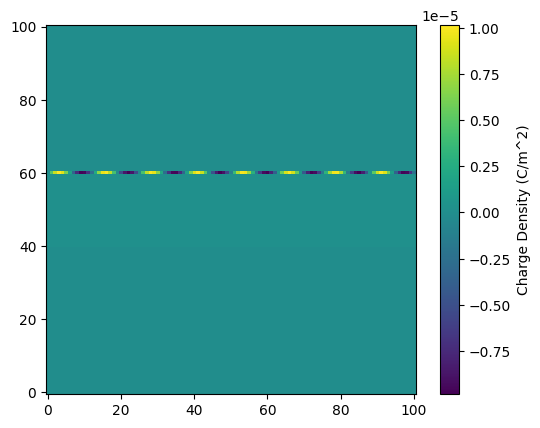

In [57]:
plt.imshow(rho, origin = 'lower')
plt.colorbar(label="Charge Density (C/m^2)",shrink=1)


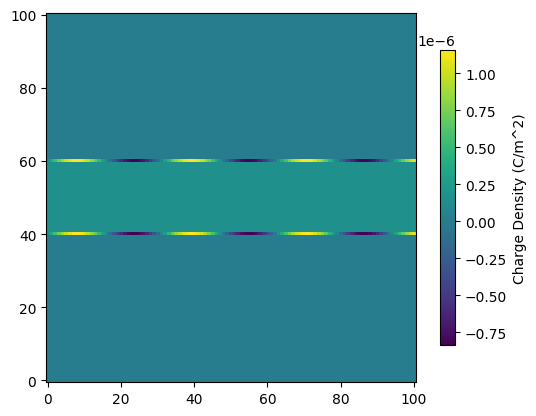

Time step 0


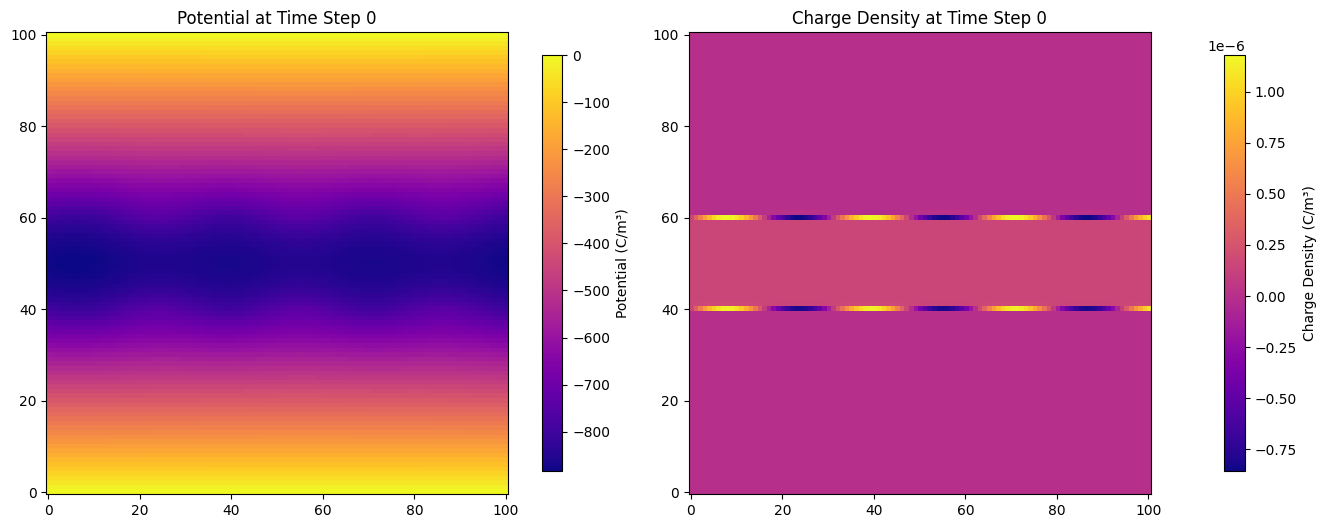

<Figure size 640x480 with 0 Axes>

Time step 10


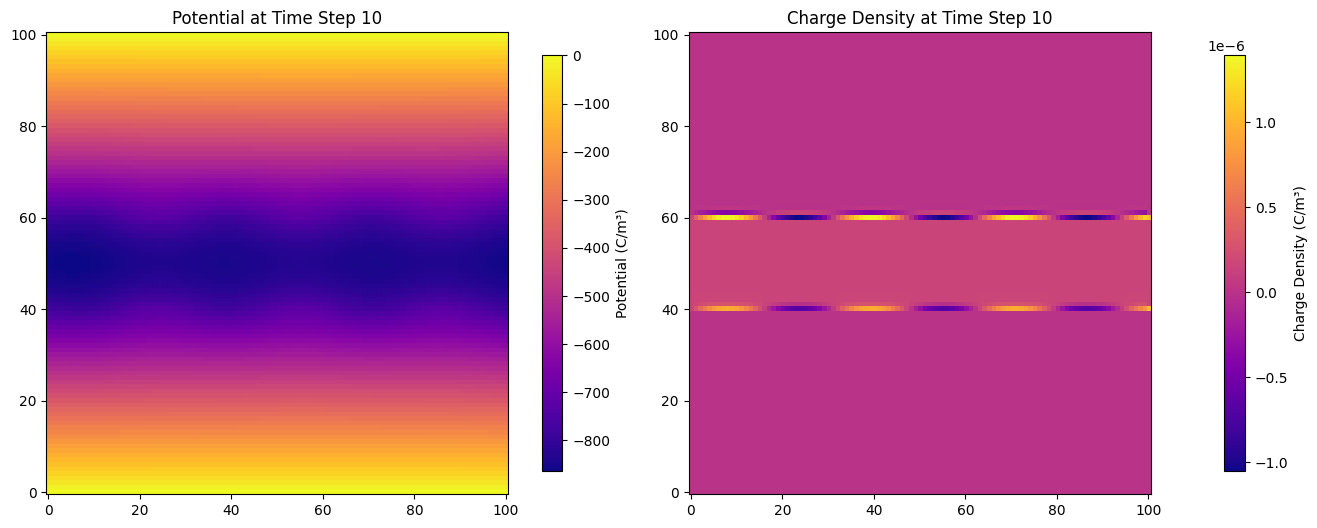

<Figure size 640x480 with 0 Axes>

Time step 20


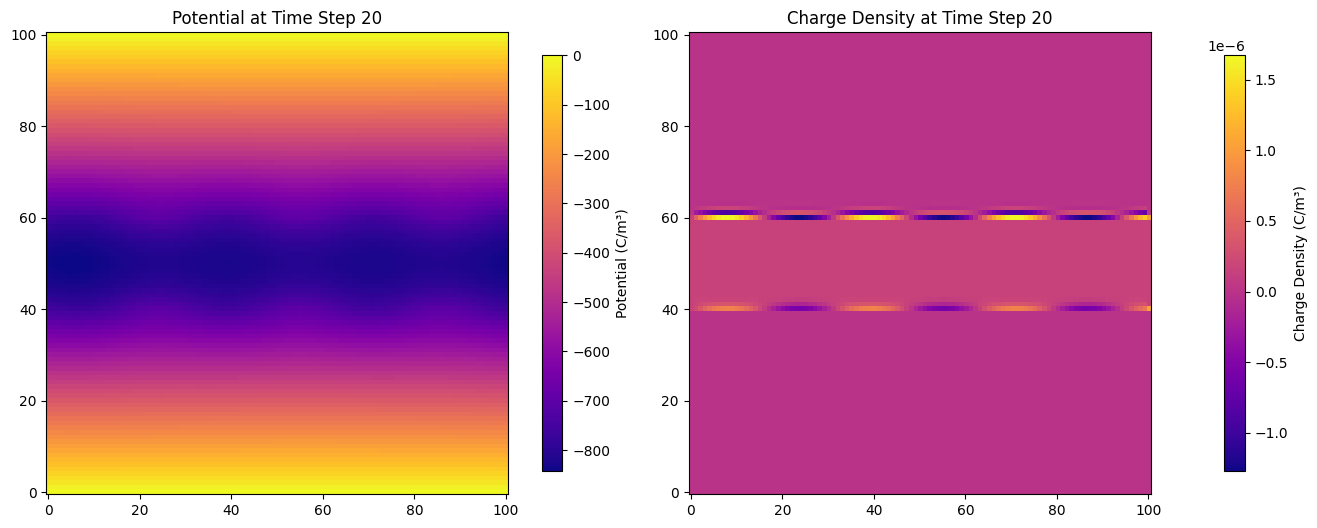

<Figure size 640x480 with 0 Axes>

Time step 30


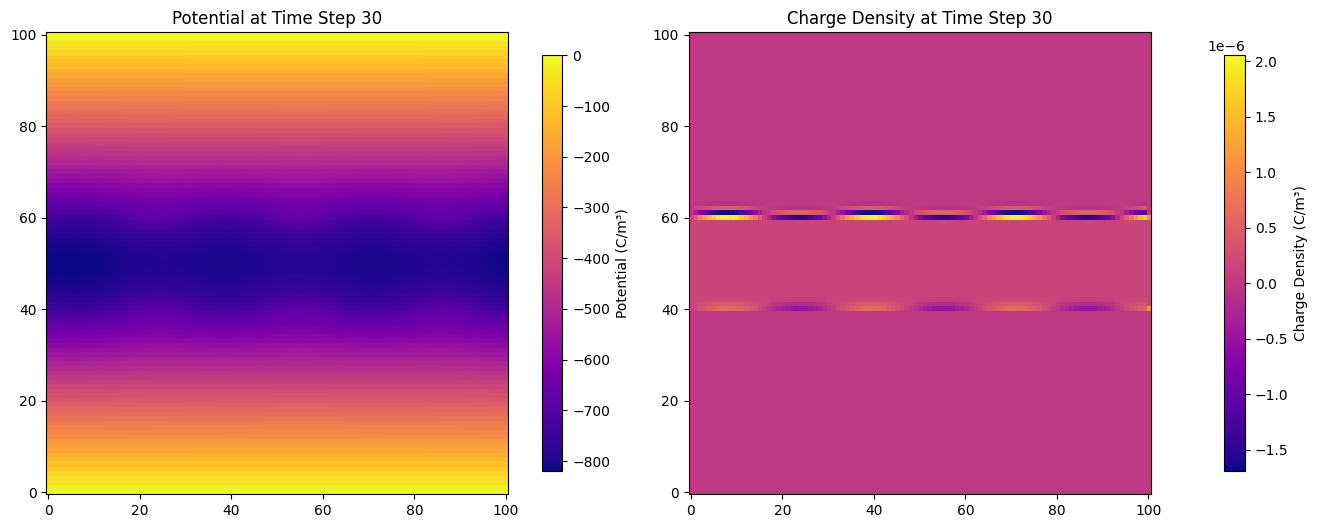

<Figure size 640x480 with 0 Axes>

Time step 40


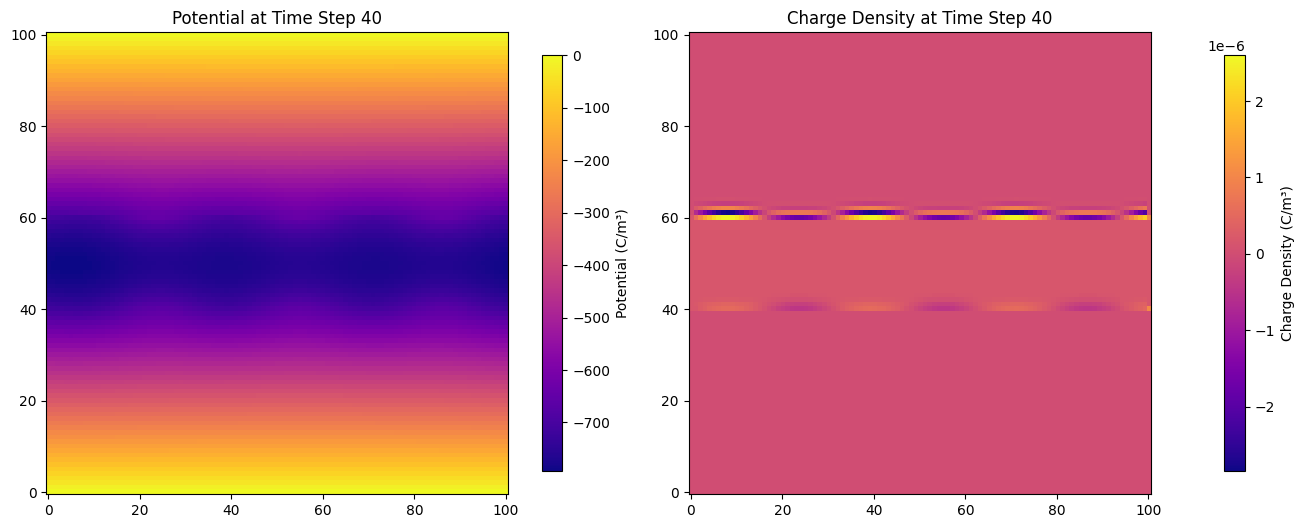

<Figure size 640x480 with 0 Axes>

Time step 50


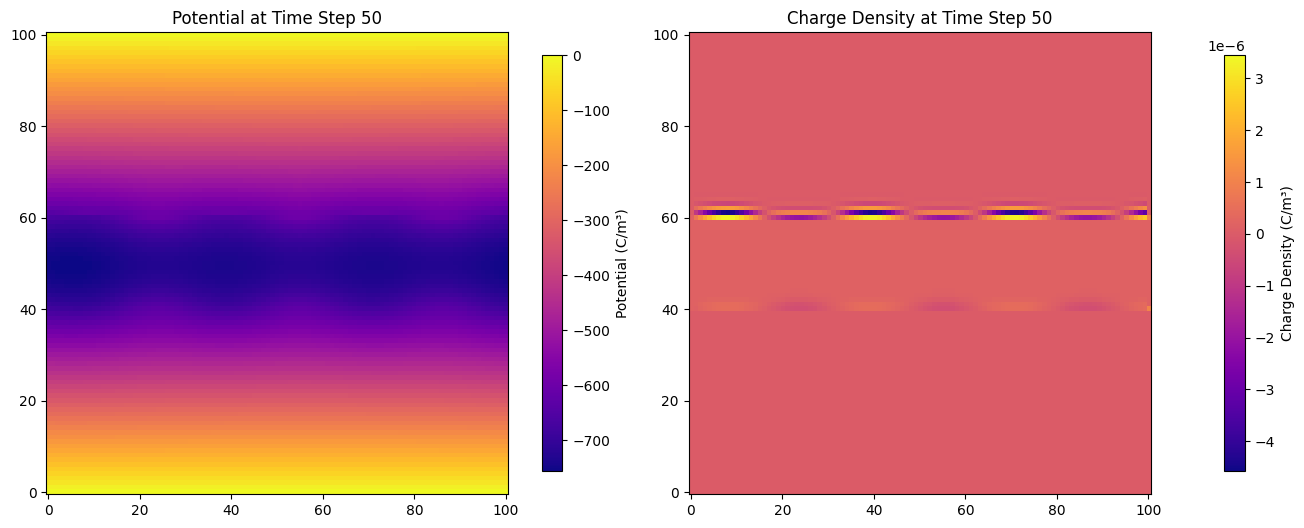

<Figure size 640x480 with 0 Axes>

Time step 60


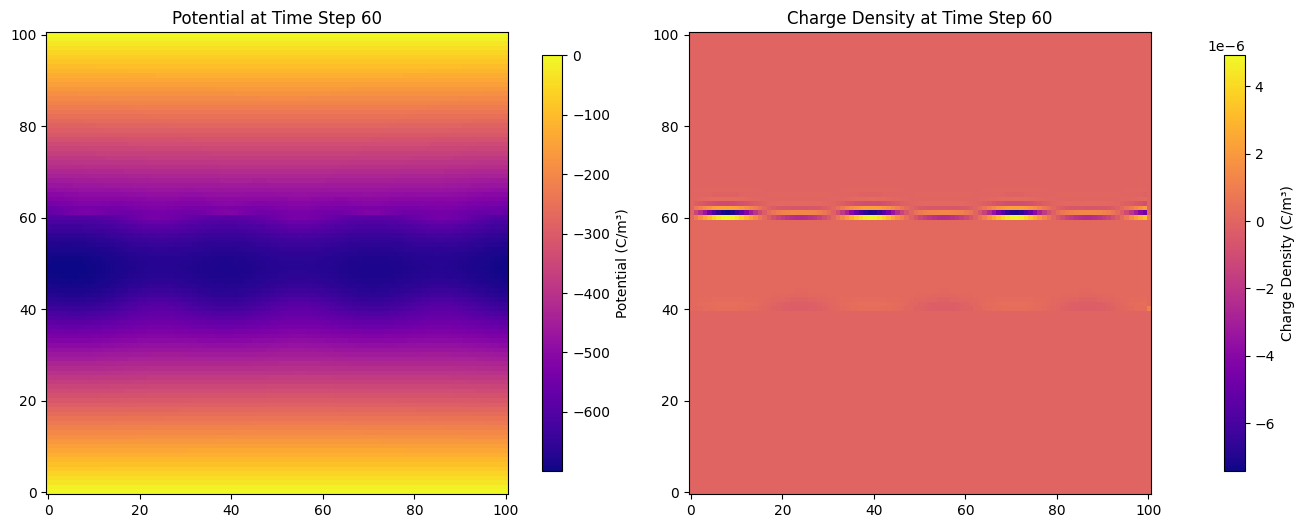

<Figure size 640x480 with 0 Axes>

Time step 70


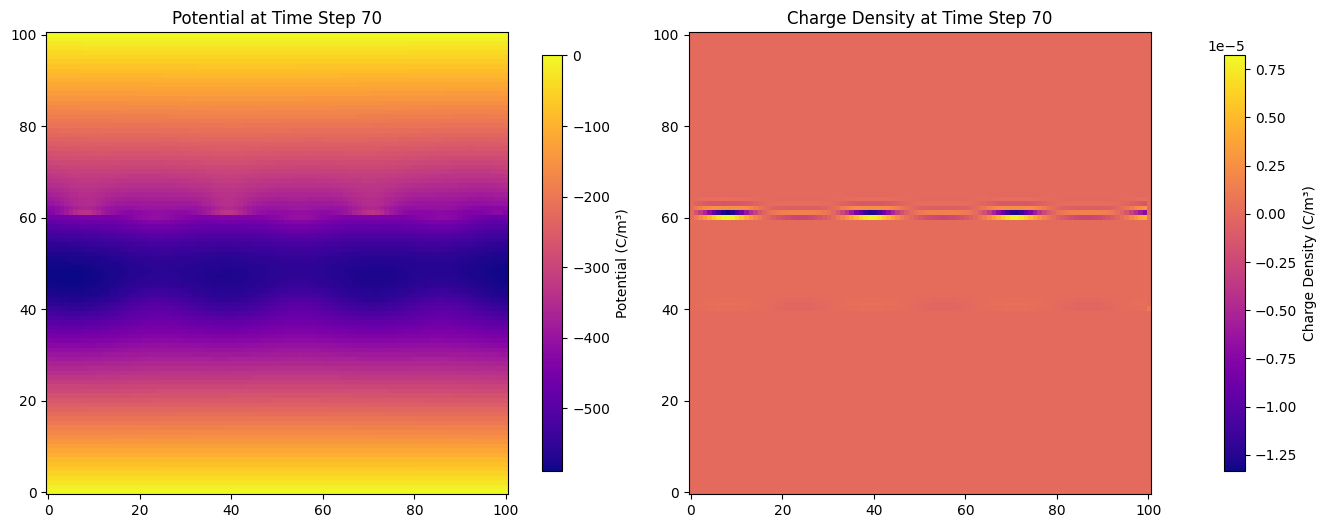

<Figure size 640x480 with 0 Axes>

Time step 80


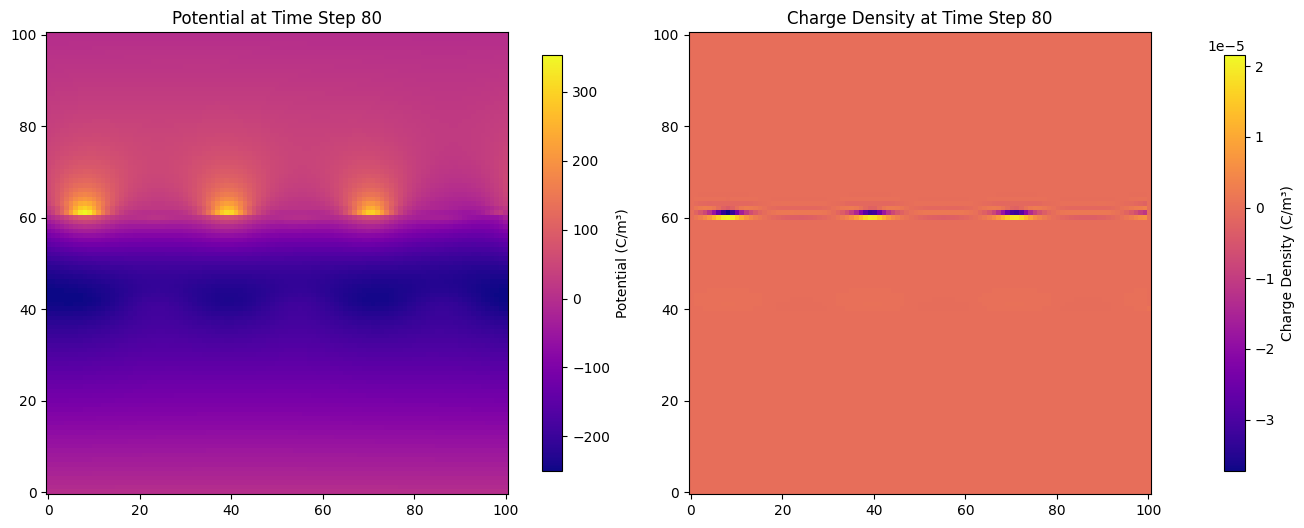

<Figure size 640x480 with 0 Axes>

Time step 90


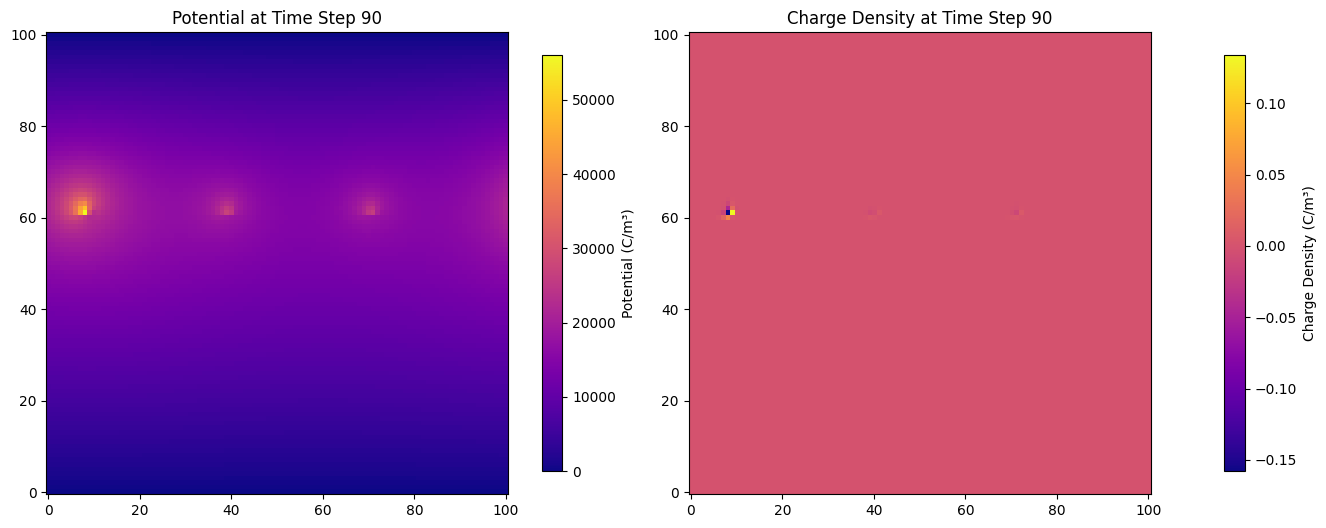

<Figure size 640x480 with 0 Axes>

/tmp/ipykernel_2595438/725336645.py:36: RuntimeWarning: overflow encountered in scalar multiply
  rho_new_time[i, j] = rho[i, j] - dt *( (rho[i, j]  - rho[i - 1, j] )* vx[i, j] /  (1*delta) +
/tmp/ipykernel_2595438/725336645.py:37: RuntimeWarning: overflow encountered in scalar multiply
  (rho[i, j]  - rho[i, j - 1] ) * vy[i, j]/ (1*delta)  )
/tmp/ipykernel_2595438/725336645.py:36: RuntimeWarning: invalid value encountered in scalar add
  rho_new_time[i, j] = rho[i, j] - dt *( (rho[i, j]  - rho[i - 1, j] )* vx[i, j] /  (1*delta) +
/tmp/ipykernel_2595438/725336645.py:37: RuntimeWarning: overflow encountered in scalar divide
  (rho[i, j]  - rho[i, j - 1] ) * vy[i, j]/ (1*delta)  )
/tmp/ipykernel_2595438/725336645.py:36: RuntimeWarning: overflow encountered in scalar divide
  rho_new_time[i, j] = rho[i, j] - dt *( (rho[i, j]  - rho[i - 1, j] )* vx[i, j] /  (1*delta) +
/tmp/ipykernel_2595438/725336645.py:37: RuntimeWarning: invalid value encountered in scalar subtract
  (rho[i, j]  - rho[i

In [60]:
#run simulation
rho = np.zeros([nx+1,ny+1],float)
rho[40:60,:] = 1e12* (1.6e-19) #C/m^2
rho[60,:] = 1e12* (1.6e-19) + 1e-6 *np.sin(0.2*x)
rho[40,:] = 1e12* (1.6e-19) + 1e-6 *np.sin(0.2*x)

plt.imshow(rho, origin = 'lower')
plt.colorbar(label="Charge Density (C/m^2)",shrink=0.8)

step = 100
for i in range (step):
    
    phi = solve_poisson_1(rho)
    Ex, Ey = electric_field(phi)
    vx, vy = velocity(Ex, Ey, B)
    rho_new = forward_euler_charge_density(rho,vx,vy,dt)
    rho =  rho_new
    
    if i % 10 == 0:
        print(f"Time step {i}")
        fig = plt.figure(figsize=(19, 6))
        ax1 = fig.add_subplot(1, 1, 1)
        plot_1 = ax1.imshow(rho_new, origin = 'lower',cmap = 'plasma')
        ax1.set_title(f"Charge Density at Time Step {i}")
        fig.colorbar(plot_1, ax=ax1, label='Charge Density (C/m³)', shrink=0.9)
        
        ax2 = fig.add_subplot(1, 2, 1)
        plot_2 = ax2.imshow(phi, origin = 'lower',cmap = 'plasma')
        ax2.set_title(f"Potential at Time Step {i}")
        fig.colorbar(plot_2, ax=ax2, label='Potential (C/m³)', shrink=0.9)
        #ax2.streamplot(X, Y, Ex, Ey, color="white", linewidth=1, cmap=plt.cm.inferno,
         #     density=1.5, arrowstyle='->', arrowsize=1.5)

        plt.show()
        plt.tight_layout()